<a href="https://colab.research.google.com/github/nandir2512/NLP/blob/main/4_Deep_Learning_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow
- Step1 - Define Input-Output Tensor Shapes
- Step2 - Define Model (Sequential, Function)
- Step3 - Compile Model (loss, Optimizer, Metrics)
- Step4 - Fit Model (Batch Size, epochs)
- Step5 - Evaluate Model
- Step6 - Prediction

# Prepare Data


In [1]:
import numpy as np, pandas as pd
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews
import random

from sklearn.model_selection import train_test_split
import seaborn as sns, matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.dpi'] = 70

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
print(len(movie_reviews.fileids()))
print(movie_reviews.categories())

2000
['neg', 'pos']


In [3]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
              for category in movie_reviews.categories()
              for fileid in movie_reviews.fileids(category)]

documents = [(text, 1) if label =="pos" else (text, 0)
              for (text, label) in documents]

random.shuffle(documents)

In [4]:
documents[2]

('towards the middle of " the sweet hereafter , " a crowded school bus skids on an icy road surface as it rounds a bend , careens through the steel guard rail , and disappears out of sight . then , in long shot , we see the vehicle slowly sliding across what looks like a snow - covered field . it pauses for a moment before the " field " cracks under the bus \' weight and the bright yellow vehicle vanishes in an effortless moment , a single smooth second of time . compare that scene , if you will , to the last eighty minutes of " titanic , " when the behemoth sinks slowly and spectacularly to its watery demise , and you \' ll appreciate the futility of comparing greatness in films . the scene in " the sweet hereafter " epitomizes all that \' s right with independent canadian director atom egoyan \' s film . it \' s not sensational . we don \' t see the inside of the bus with its payload of screaming , terrified children being bloodied and battered about . the bus doesn \' t explode or b

## Train-Test Split

In [5]:
train_set, test_set = train_test_split(documents, test_size=0.1, random_state=42)

print(len(train_set), len(test_set))

1800 200


In [6]:
## Dependencies
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Bidirectional, Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GlobalAveragePooling1D

## Prepare Input and Output Tensors

In [7]:
# Dummy Code
x = [(1, 2), (3, 4), (5, 6)]
print([n for (n,l) in x])
print([l for (n,l) in x])

[1, 3, 5]
[2, 4, 6]


In [8]:
# Split data into X (texts) and y (labels)
texts = [n for (n,l) in train_set]
labels = [l for (n,l) in train_set]

print(len(texts))
print(len(labels))


1800
1800


# Tokenizer

- For text vectorization, we will implement two alternatives:

    - Texts to Matrix: One-hot encoding of texts (similar to bag-of-words model)

    - Texts to Sequences: Integer encoding of all word tokens in texts and we will learn token embeddings along with the networks

We set the num_words at 10000, meaning that the Tokenizer will automatically include only the most frequent 10000 words in the later text vectorization.

In [9]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(texts)

## Vocabulary
When oov_token is specified, the unknown word tokens (i.e., words that are not in the top 10000 words) will be replaced with this oov_token token, instead of being removed from the texts.

In [10]:
# Determine the vocabulary size
vocab_size = tokenizer.num_words +1
print('Vocabulary Size: %d' %vocab_size)

Vocabulary Size: 10001


In [11]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('this', 15),
 ('film', 16),
 ('his', 17),
 ('he', 18),
 ('i', 19),
 ('but', 20)]

In [12]:
len(tokenizer.word_index)

37768

# Method 1: Text to Sequences
####  Text to sequences (integers)
####  Pad sequences

In [13]:
texts_ints = tokenizer.texts_to_sequences(texts)

print(len(texts[20].split(' ')))
print(len(texts_ints[20]))

661
549


[878, 570, 1192, 1016, 864, 1252, 576, 388, 700, 552, 761, 627, 466, 576, 334, 1150, 276, 371, 1539, 1232, 549, 719, 408, 692, 266, 842, 768, 404, 413, 1028, 259, 319, 1414, 458, 590, 316, 278, 346, 495, 715, 697, 618, 891, 568, 817, 399, 266, 649, 708, 206, 733, 803, 704, 1365, 654, 659, 1026, 1051, 508, 557, 701, 361, 842, 1769, 556, 773, 765, 273, 396, 428, 645, 618, 1091, 414, 534, 1311, 809, 363, 896, 836, 942, 457, 782, 909, 466, 1211, 493, 728, 849, 776, 542, 812, 282, 936, 837, 374, 434, 859, 867, 1103, 281, 448, 919, 591, 714, 560, 779, 213, 983, 624, 1233, 780, 1017, 84, 997, 978, 401, 934, 613, 904, 487, 570, 318, 669, 738, 476, 669, 558, 749, 909, 1655, 832, 611, 614, 228, 648, 655, 1072, 497, 163, 672, 588, 537, 521, 498, 640, 880, 257, 489, 556, 688, 330, 785, 436, 367, 803, 424, 803, 152, 680, 819, 530, 640, 247, 564, 617, 322, 315, 572, 695, 508, 673, 581, 456, 920, 717, 587, 926, 412, 251, 503, 459, 713, 562, 507, 491, 855, 1784, 964, 234, 1359, 448, 527, 813, 281, 752

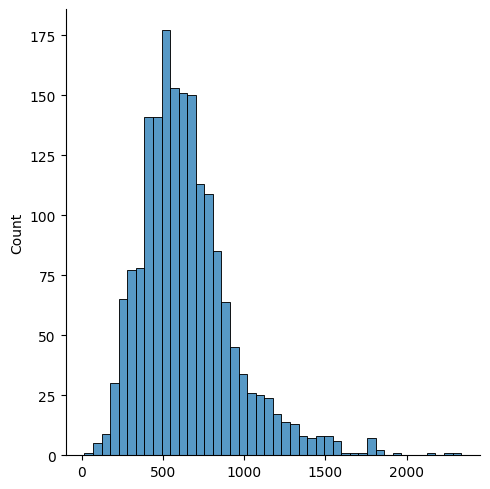

In [14]:
## Check the text len distribution

texts_lens = [len(n) for n in texts_ints]
print(texts_lens)

sns.displot(texts_lens)

In [15]:
# Find the maxlen of the texts

max_len = texts_lens[np.argmax(texts_lens)]
max_len

2335

* Here, we consider only the final 400 tokens of each text, using the following parameters for pad_sequences().

* We keep the final 400 tokens from the text (truncating='pre').

* If the text is shorter than 400 tokens, we pad the text to 400 tokens at the beginning of the text (padding='pre').

In [16]:
## padding

max_len = 400
texts_ints_pad = sequence.pad_sequences(texts_ints,
                                       maxlen = max_len,
                                       truncating = 'pre',
                                       padding='pre')
texts_ints_pad[:10]

array([[  40,   22,   75, ...,   28,  544, 8817],
       [  18, 1088,   34, ...,    5,  735, 1831],
       [ 270, 1037,   56, ...,    6,    9,  360],
       ...,
       [   0,    0,    0, ..., 2247,   91,  106],
       [   3,   19,   60, ..., 4904, 1349,   33],
       [   8,    2,  334, ..., 2427, 1235, 1236]], dtype=int32)

In [17]:
# gereate X and y for training
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

## Generate X and y for testing in the same way
X_test_texts = [n for (n,l) in test_set]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen = max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')

y_test = np.array([l for (n,l) in test_set])

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding/Bag-of-Words)

In [19]:
## Texts to One-Hot Encoding (bag of words)

texts_matrix = tokenizer.texts_to_matrix(texts, mode="binary")
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

## Same for Testing Data
X_test2 = tokenizer.texts_to_matrix(X_test_texts, mode="binary").astype('int32')
y_test2 = np.array([l for (n,l) in test_set])

In [20]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


# Function for Plot

In [21]:
# Plotting results

def plot1(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  ## Accuracy plot
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  ## Loss plot
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

def plot2(history):
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.show()

### Hyperparameters


In [22]:
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

# Model 1
* Two layers of fully-connected dense layers.
* The input is the one-hot encoding of the text from text-to-matrix.

In [23]:
model1 = Sequential()
model1.add(Input(shape=(NUM_WORDS,)))
model1.add(Dense(16, activation="relu", name="dense_layer_1"))
model1.add(Dense(16, activation="relu", name="dense_layer_2"))
model1.add(Dense(1, activation="sigmoid", name="output"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer_1 (Dense)       (None, 16)                160016    
                                                                 
 dense_layer_2 (Dense)       (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 160305 (626.19 KB)
Trainable params: 160305 (626.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


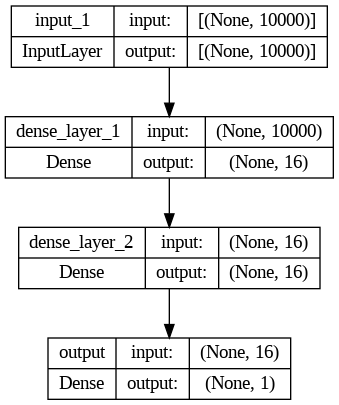

In [24]:
plot_model(model1, show_shapes=True)

In [25]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [26]:
history1 = model1.fit(X_train2, y_train2, batch_size=BATCH_SIZE,
                      epochs = EPOCHS, verbose=2,
                      validation_split= VALIDATION_SPLIT)

Epoch 1/25
12/12 - 2s - loss: 0.6602 - accuracy: 0.6153 - val_loss: 0.5994 - val_accuracy: 0.7194 - 2s/epoch - 202ms/step
Epoch 2/25
12/12 - 0s - loss: 0.4394 - accuracy: 0.9097 - val_loss: 0.4624 - val_accuracy: 0.8556 - 230ms/epoch - 19ms/step
Epoch 3/25
12/12 - 0s - loss: 0.2529 - accuracy: 0.9708 - val_loss: 0.3816 - val_accuracy: 0.8611 - 291ms/epoch - 24ms/step
Epoch 4/25
12/12 - 0s - loss: 0.1397 - accuracy: 0.9924 - val_loss: 0.3434 - val_accuracy: 0.8639 - 264ms/epoch - 22ms/step
Epoch 5/25
12/12 - 0s - loss: 0.0764 - accuracy: 0.9972 - val_loss: 0.3203 - val_accuracy: 0.8722 - 258ms/epoch - 21ms/step
Epoch 6/25
12/12 - 0s - loss: 0.0421 - accuracy: 1.0000 - val_loss: 0.3082 - val_accuracy: 0.8667 - 277ms/epoch - 23ms/step
Epoch 7/25
12/12 - 0s - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.3077 - val_accuracy: 0.8667 - 211ms/epoch - 18ms/step
Epoch 8/25
12/12 - 0s - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.3109 - val_accuracy: 0.8667 - 209ms/epoch - 17ms/step
Epoch 9/25

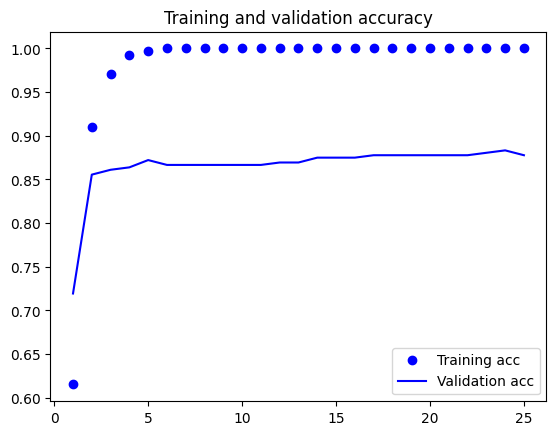

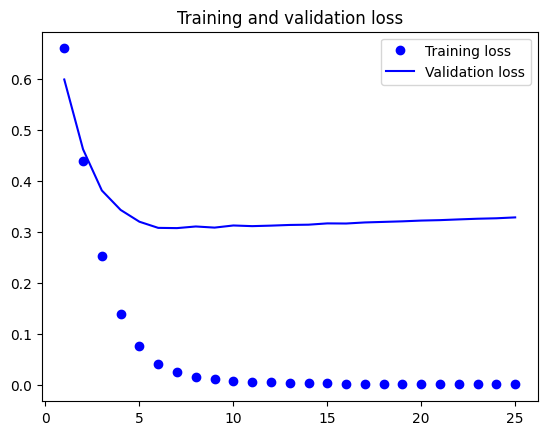

In [27]:
plot1(history1)

In [28]:
# Model Evaluation
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.2762 - accuracy: 0.8850 - 107ms/epoch - 53ms/step


[0.27616018056869507, 0.8849999904632568]

# Model2
* One Embedding Layer + Two fully-connected dense layers
* The inpus are from text to sequences(integers) of texts


 The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.


In [29]:
model2 = Sequential()
model2.add(
    Embedding(input_dim= vocab_size, output_dim = EMBEDDING_DIM,
              input_length=max_len, mask_zero=True))

model2.add(GlobalAveragePooling1D())
model2.add(Dense(16, activation="relu", name="dense_layer_1"))
model2.add(Dense(16, activation="relu", name="dense_layer_2"))
model2.add(Dense(1, activation="sigmoid", name="output"))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 128)          1280128   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_layer_1 (Dense)       (None, 16)                2064      
                                                                 
 dense_layer_2 (Dense)       (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1282481 (4.89 MB)
Trainable params: 1282481 (4.89 MB)
Non-trainable params: 0 (0.00 Byte)
________________

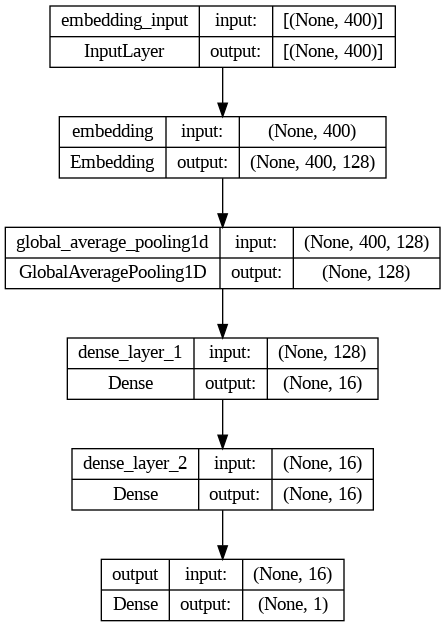

In [30]:
plot_model(model2, show_shapes=True)

In [31]:
model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

In [32]:
history2 = model2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 4s - loss: 0.6920 - accuracy: 0.5931 - val_loss: 0.6893 - val_accuracy: 0.7083 - 4s/epoch - 361ms/step
Epoch 2/25
12/12 - 1s - loss: 0.6855 - accuracy: 0.7910 - val_loss: 0.6833 - val_accuracy: 0.7972 - 1s/epoch - 87ms/step
Epoch 3/25
12/12 - 1s - loss: 0.6741 - accuracy: 0.8562 - val_loss: 0.6726 - val_accuracy: 0.8250 - 561ms/epoch - 47ms/step
Epoch 4/25
12/12 - 1s - loss: 0.6545 - accuracy: 0.8819 - val_loss: 0.6564 - val_accuracy: 0.8306 - 560ms/epoch - 47ms/step
Epoch 5/25
12/12 - 1s - loss: 0.6241 - accuracy: 0.9028 - val_loss: 0.6314 - val_accuracy: 0.8472 - 534ms/epoch - 45ms/step
Epoch 6/25
12/12 - 1s - loss: 0.5801 - accuracy: 0.9160 - val_loss: 0.5994 - val_accuracy: 0.8528 - 535ms/epoch - 45ms/step
Epoch 7/25
12/12 - 1s - loss: 0.5220 - accuracy: 0.9431 - val_loss: 0.5587 - val_accuracy: 0.8639 - 559ms/epoch - 47ms/step
Epoch 8/25
12/12 - 1s - loss: 0.4511 - accuracy: 0.9604 - val_loss: 0.5187 - val_accuracy: 0.8306 - 549ms/epoch - 46ms/step
Epoch 9/25
12

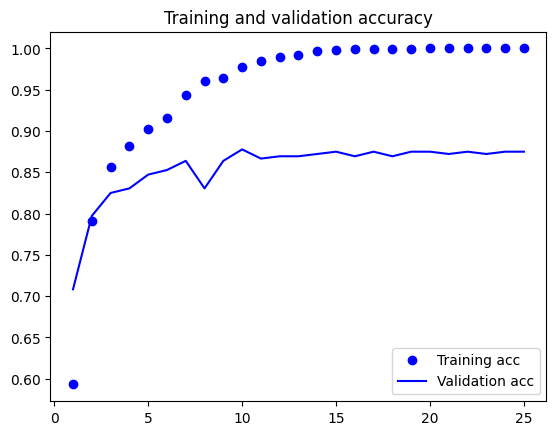

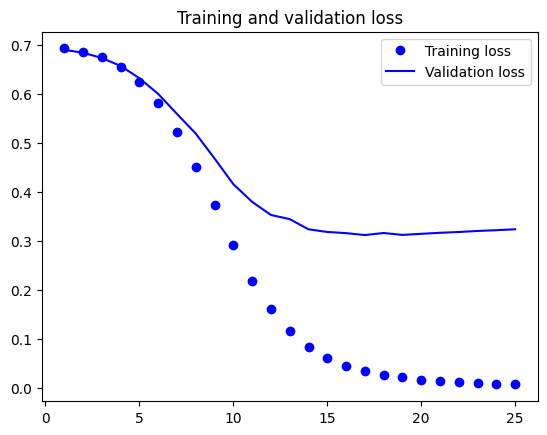

In [33]:
plot1(history2)

In [34]:
model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.2925 - accuracy: 0.8700 - 40ms/epoch - 20ms/step


[0.2925334572792053, 0.8700000047683716]

# Sequence Models

# Model 3
* One Embedding Layer + LSTM + Dense Layer
* Input: the text sequences (padded)



In [35]:
model3 = Sequential()
model3.add( Embedding(input_dim=vocab_size,
                      output_dim= EMBEDDING_DIM,
                      input_length=max_len,
                      mask_zero=True))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

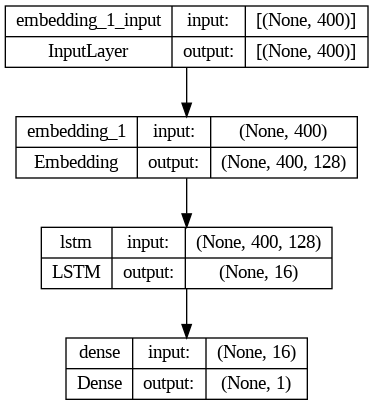

In [36]:
plot_model(model3, show_shapes=True)

In [37]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 128)          1280128   
                                                                 
 lstm (LSTM)                 (None, 16)                9280      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1289425 (4.92 MB)
Trainable params: 1289425 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
history3 = model3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 18s - loss: 0.6919 - accuracy: 0.5368 - val_loss: 0.6885 - val_accuracy: 0.6194 - 18s/epoch - 2s/step
Epoch 2/25
12/12 - 13s - loss: 0.6733 - accuracy: 0.7535 - val_loss: 0.6809 - val_accuracy: 0.6194 - 13s/epoch - 1s/step
Epoch 3/25
12/12 - 13s - loss: 0.6282 - accuracy: 0.8188 - val_loss: 0.6448 - val_accuracy: 0.6583 - 13s/epoch - 1s/step
Epoch 4/25
12/12 - 13s - loss: 0.4915 - accuracy: 0.8493 - val_loss: 0.5390 - val_accuracy: 0.7333 - 13s/epoch - 1s/step
Epoch 5/25
12/12 - 13s - loss: 0.3914 - accuracy: 0.8965 - val_loss: 0.5512 - val_accuracy: 0.7444 - 13s/epoch - 1s/step
Epoch 6/25
12/12 - 13s - loss: 0.3129 - accuracy: 0.9243 - val_loss: 0.5166 - val_accuracy: 0.7361 - 13s/epoch - 1s/step
Epoch 7/25
12/12 - 14s - loss: 0.2397 - accuracy: 0.9715 - val_loss: 0.5348 - val_accuracy: 0.7639 - 14s/epoch - 1s/step
Epoch 8/25
12/12 - 14s - loss: 0.1767 - accuracy: 0.9826 - val_loss: 0.4708 - val_accuracy: 0.7806 - 14s/epoch - 1s/step
Epoch 9/25
12/12 - 14s - loss: 0

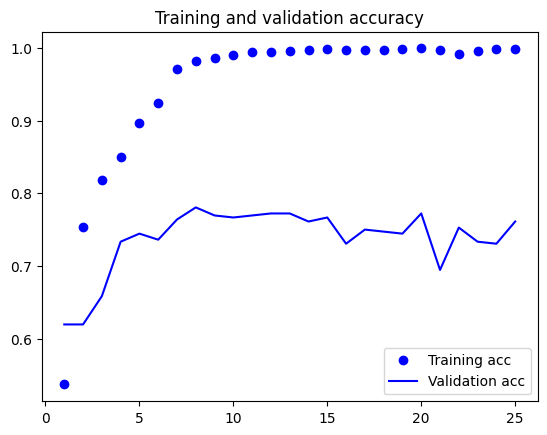

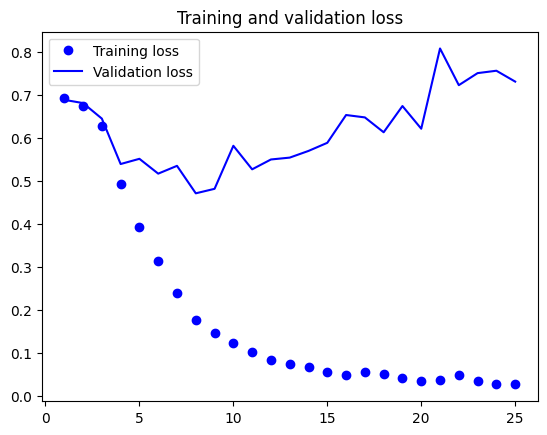

In [39]:
plot1(history3)

In [40]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.7698 - accuracy: 0.7400 - 221ms/epoch - 111ms/step


[0.7698347568511963, 0.7400000095367432]

# Model 4
* One Embdding Layer + Two Stacked LSTM + Dense Layer
* Inputs: text sequences (padded)

In [41]:
## Model 4
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size,
                     output_dim=EMBEDDING_DIM,
                     input_length=max_len,
                     mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model4.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid"))

model4.compile(loss='binary_crossentropy', optimizer='adam',
               metrics=["accuracy"])

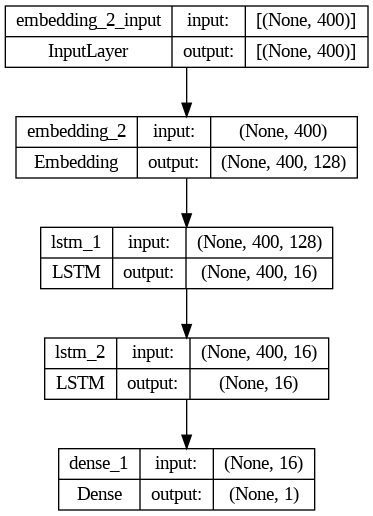

In [42]:
plot_model(model4, show_shapes=True)

In [43]:
history4 = model4.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 29s - loss: 0.6921 - accuracy: 0.5299 - val_loss: 0.6898 - val_accuracy: 0.5667 - 29s/epoch - 2s/step
Epoch 2/25
12/12 - 21s - loss: 0.6717 - accuracy: 0.7604 - val_loss: 0.6750 - val_accuracy: 0.6083 - 21s/epoch - 2s/step
Epoch 3/25
12/12 - 21s - loss: 0.5935 - accuracy: 0.8354 - val_loss: 0.6182 - val_accuracy: 0.6750 - 21s/epoch - 2s/step
Epoch 4/25
12/12 - 20s - loss: 0.3940 - accuracy: 0.8736 - val_loss: 0.5410 - val_accuracy: 0.7306 - 20s/epoch - 2s/step
Epoch 5/25
12/12 - 22s - loss: 0.2067 - accuracy: 0.9389 - val_loss: 0.5755 - val_accuracy: 0.7417 - 22s/epoch - 2s/step
Epoch 6/25
12/12 - 21s - loss: 0.1156 - accuracy: 0.9785 - val_loss: 0.5854 - val_accuracy: 0.7528 - 21s/epoch - 2s/step
Epoch 7/25
12/12 - 20s - loss: 0.0745 - accuracy: 0.9896 - val_loss: 0.6398 - val_accuracy: 0.7472 - 20s/epoch - 2s/step
Epoch 8/25
12/12 - 21s - loss: 0.0485 - accuracy: 0.9951 - val_loss: 0.7686 - val_accuracy: 0.7333 - 21s/epoch - 2s/step
Epoch 9/25
12/12 - 22s - loss: 0

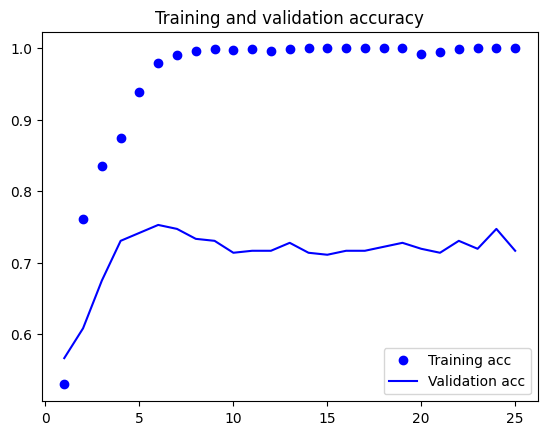

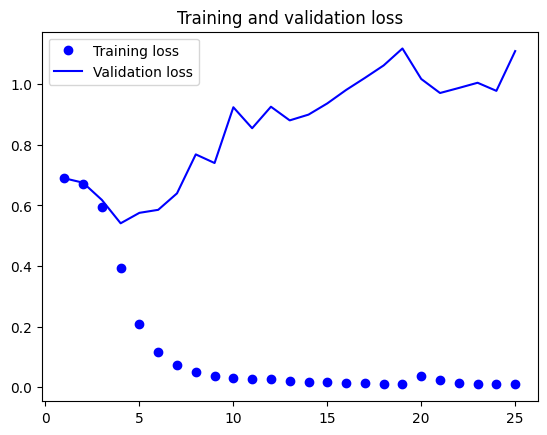

In [44]:
plot1(history4)

In [45]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.0529 - accuracy: 0.7450 - 361ms/epoch - 181ms/step


[1.0529180765151978, 0.7450000047683716]

# Model 5
* Embedding Layer + Bidirectional LSTM + Dense Layer
* Inputs: Text sequences (padded)

In [46]:
## Model 5
model5 = Sequential()
model5.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model5.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(1, activation="sigmoid"))

model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])

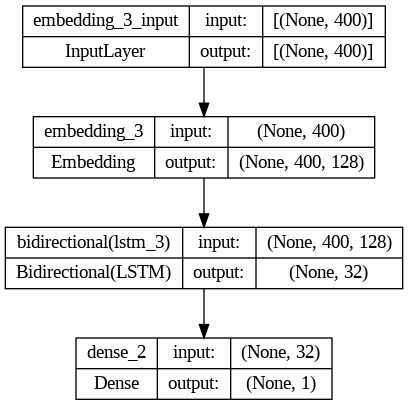

In [47]:
plot_model(model5, show_shapes=True)

In [48]:
history5 = model5.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=0.2)

Epoch 1/25
12/12 - 37s - loss: 0.6924 - accuracy: 0.5250 - val_loss: 0.6903 - val_accuracy: 0.5639 - 37s/epoch - 3s/step
Epoch 2/25
12/12 - 28s - loss: 0.6758 - accuracy: 0.7326 - val_loss: 0.6875 - val_accuracy: 0.5639 - 28s/epoch - 2s/step
Epoch 3/25
12/12 - 27s - loss: 0.6443 - accuracy: 0.9042 - val_loss: 0.6773 - val_accuracy: 0.5972 - 27s/epoch - 2s/step
Epoch 4/25
12/12 - 27s - loss: 0.5619 - accuracy: 0.9111 - val_loss: 0.6357 - val_accuracy: 0.6250 - 27s/epoch - 2s/step
Epoch 5/25
12/12 - 27s - loss: 0.3876 - accuracy: 0.8917 - val_loss: 0.5327 - val_accuracy: 0.7611 - 27s/epoch - 2s/step
Epoch 6/25
12/12 - 28s - loss: 0.2314 - accuracy: 0.9625 - val_loss: 0.5176 - val_accuracy: 0.7667 - 28s/epoch - 2s/step
Epoch 7/25
12/12 - 27s - loss: 0.1561 - accuracy: 0.9806 - val_loss: 0.4938 - val_accuracy: 0.7861 - 27s/epoch - 2s/step
Epoch 8/25
12/12 - 27s - loss: 0.1102 - accuracy: 0.9896 - val_loss: 0.4844 - val_accuracy: 0.7972 - 27s/epoch - 2s/step
Epoch 9/25
12/12 - 27s - loss: 0

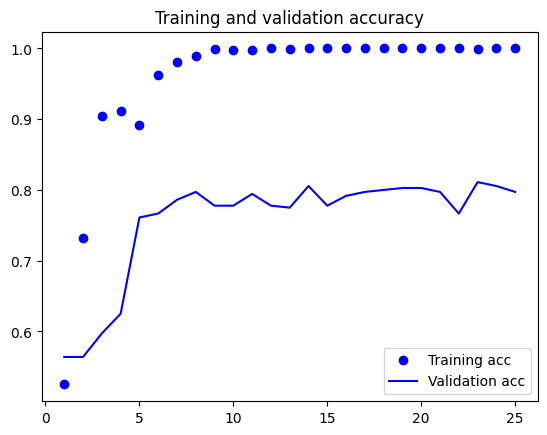

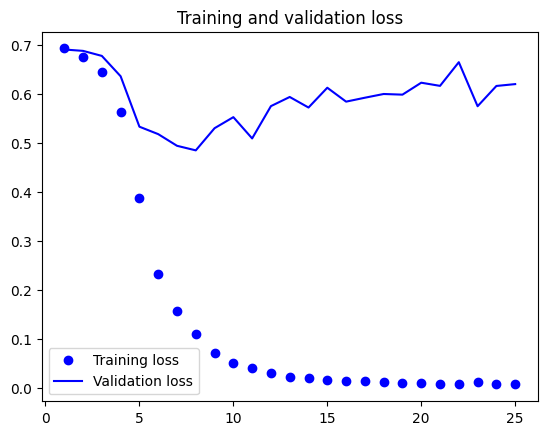

In [49]:
plot1(history5)

In [50]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.6809 - accuracy: 0.7750 - 434ms/epoch - 217ms/step


[0.6809241771697998, 0.7749999761581421]

# Even More Complex Sequence Models


# Model 6
* One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer
* Inputs: Text sequences (padded)


######  LSTM Parameters:
* `return_seqeunces=True`: return the hidden states for each time step
* `return_state=True`: return the cell state of the last time step
* When both are set True, the return values of LSTM are:
  * (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
  * (2) the hidden state of the last time step
  * (3) the cell state of the last time step

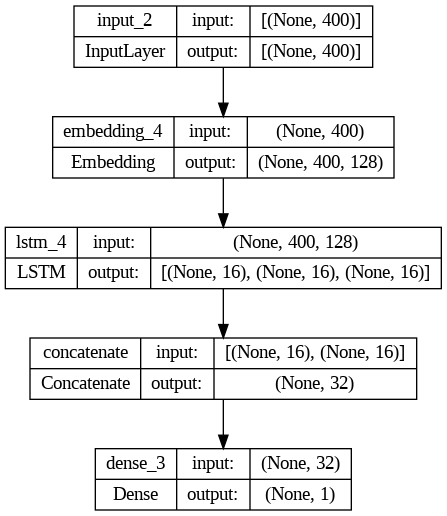

In [51]:
## Model 6
## Function API

inputs= Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM,
              input_length=max_len, mask_zero=True)(inputs)

_, x_last_h, x_c = LSTM(16, dropout=0.2, recurrent_dropout=0.2,
                        return_sequences=False, return_state=True)(x)
x= Concatenate(axis=1)([x_last_h, x_c])
outputs = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=inputs, outputs=outputs)

plot_model(model6, show_shapes=True)

In [52]:
model6.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history6 = model6.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 17s - loss: 0.6922 - accuracy: 0.5215 - val_loss: 0.6908 - val_accuracy: 0.5389 - 17s/epoch - 1s/step
Epoch 2/25
12/12 - 13s - loss: 0.6756 - accuracy: 0.7632 - val_loss: 0.6868 - val_accuracy: 0.5556 - 13s/epoch - 1s/step
Epoch 3/25
12/12 - 13s - loss: 0.6379 - accuracy: 0.8389 - val_loss: 0.6686 - val_accuracy: 0.6028 - 13s/epoch - 1s/step
Epoch 4/25
12/12 - 13s - loss: 0.5200 - accuracy: 0.8722 - val_loss: 0.5441 - val_accuracy: 0.7500 - 13s/epoch - 1s/step
Epoch 5/25
12/12 - 13s - loss: 0.3128 - accuracy: 0.9007 - val_loss: 0.5161 - val_accuracy: 0.7722 - 13s/epoch - 1s/step
Epoch 6/25
12/12 - 13s - loss: 0.1926 - accuracy: 0.9639 - val_loss: 0.4828 - val_accuracy: 0.7722 - 13s/epoch - 1s/step
Epoch 7/25
12/12 - 13s - loss: 0.1039 - accuracy: 0.9722 - val_loss: 0.4555 - val_accuracy: 0.7778 - 13s/epoch - 1s/step
Epoch 8/25
12/12 - 13s - loss: 0.0689 - accuracy: 0.9924 - val_loss: 0.5284 - val_accuracy: 0.7639 - 13s/epoch - 1s/step
Epoch 9/25
12/12 - 13s - loss: 0

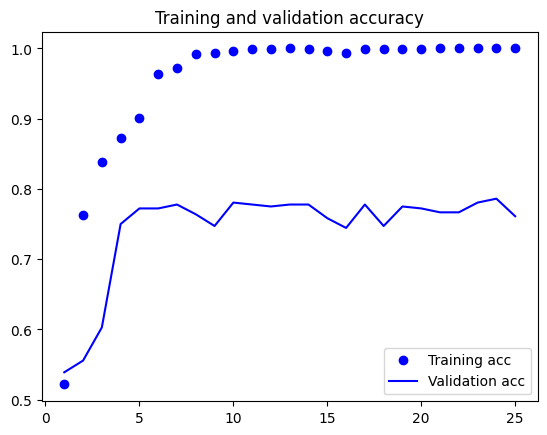

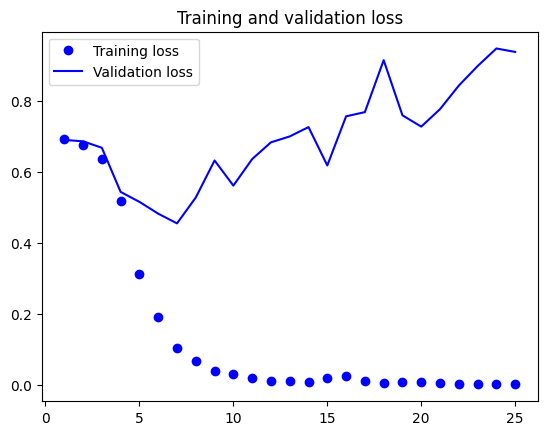

In [53]:
plot1(history6)

In [54]:
model6.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.1191 - accuracy: 0.6950 - 210ms/epoch - 105ms/step


[1.119130253791809, 0.6949999928474426]

# Model 7
* Embedding + LSTM + Self-Attention + Dense
* Inputs: Text sequences
* All of the previous RNN-based models only utilize the output of the last time step from the RNN as the input of the decision-making Dense layer.
* We can also make all the hidden outputs at all time steps from the RNN available to decision-making Dense layer.
* This is the idea of Attention.
* Here we add one Self-Attention layer, which gives us a weighted version of all the hidden states from the RNN.
* Self Attention layer is a simple sequence-to-sequence layer, which takes in a set of input tensors and returns a set of output tensors.
* In Self Attention Layer, each output vector is transformed by considering the pairwise similarities of its corresponding input vector and all the other input vectors.
* We will come back to the Attention mechanism in the later unit for more details.




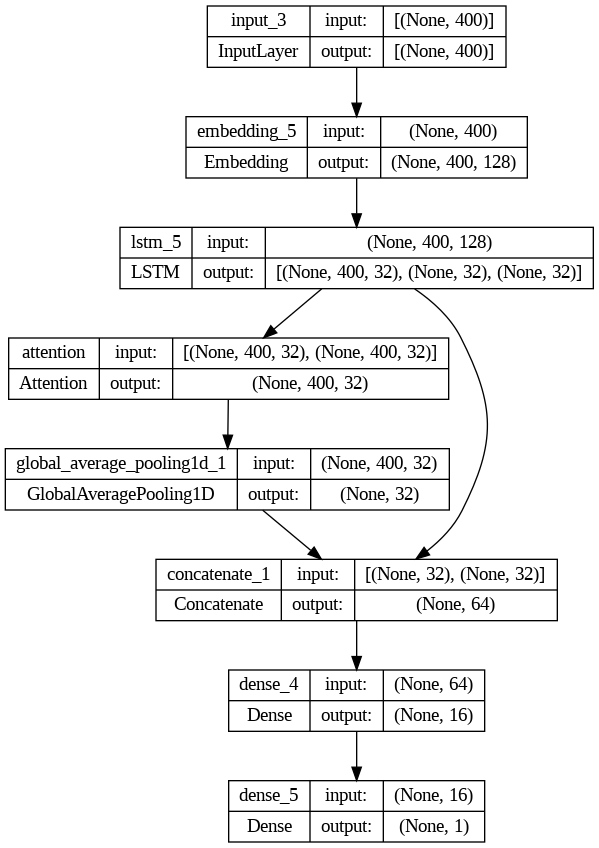

In [55]:
## Model 7 (Self-Attention)

inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(x)
## Self Attention

atten_out = Attention()([x_all_hs, x_all_hs]) #query and key
atten_out_average = GlobalAveragePooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation="relu")(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=inputs, outputs=outputs)

plot_model(model7, show_shapes=True)

In [56]:
model7.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 400, 128)             1280128   ['input_3[0][0]']             
                                                                                                  
 lstm_5 (LSTM)               [(None, 400, 32),            20608     ['embedding_5[0][0]']         
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                            

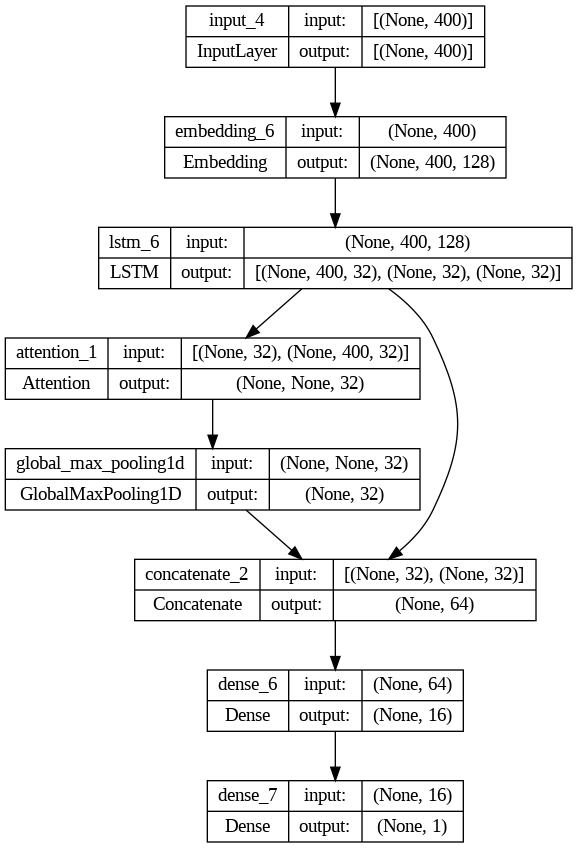

In [57]:
## Model 7_1 (Attention of lasth on allh)

inputs = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

## Self Attention
atten_out = Attention()([x_last_h, x_all_hs])  # Attention of last hidden states on all preceding states
atten_out_average = layers.GlobalMaxPooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation="relu")(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model7_1 = Model(inputs=inputs, outputs=outputs)

plot_model(model7_1, show_shapes=True)

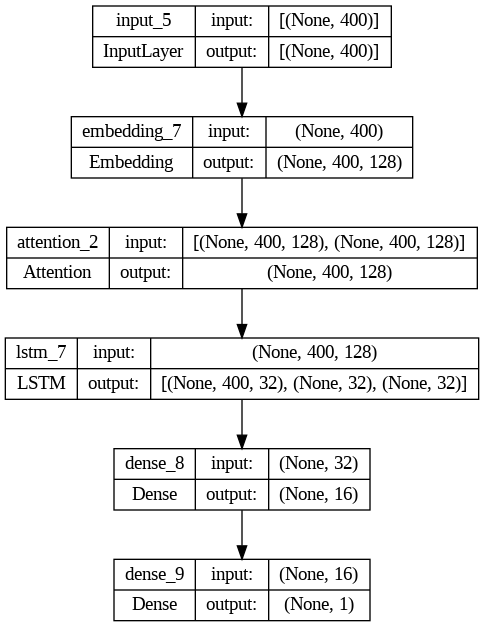

In [58]:
## Model 7_2 (Self-Attention before RNN)

inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True)(inputs)

atten_out = Attention()([x,x])

x_all_hs, x_last_h, x_last_c = LSTM(32,
                                    dropout=0.2,
                                    recurrent_dropout=0.2,
                                    return_sequences=True,
                                    return_state=True)(atten_out)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = Dense(16, activation="relu")(x_last_h)
outputs = Dense(1, activation='sigmoid')(x)
model7_2 = Model(inputs=inputs, outputs=outputs)

plot_model(model7_2, show_shapes=True)

In [59]:
model7.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=["accuracy"])
history7 = model7.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=2,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 27s - loss: 0.6928 - accuracy: 0.5222 - val_loss: 0.6919 - val_accuracy: 0.5639 - 27s/epoch - 2s/step
Epoch 2/25
12/12 - 22s - loss: 0.6839 - accuracy: 0.7410 - val_loss: 0.6866 - val_accuracy: 0.5972 - 22s/epoch - 2s/step
Epoch 3/25
12/12 - 22s - loss: 0.6511 - accuracy: 0.8313 - val_loss: 0.6555 - val_accuracy: 0.6583 - 22s/epoch - 2s/step
Epoch 4/25
12/12 - 21s - loss: 0.5137 - accuracy: 0.8625 - val_loss: 0.5280 - val_accuracy: 0.7778 - 21s/epoch - 2s/step
Epoch 5/25
12/12 - 22s - loss: 0.2852 - accuracy: 0.9368 - val_loss: 0.5794 - val_accuracy: 0.7750 - 22s/epoch - 2s/step
Epoch 6/25
12/12 - 23s - loss: 0.1689 - accuracy: 0.9528 - val_loss: 0.5075 - val_accuracy: 0.7722 - 23s/epoch - 2s/step
Epoch 7/25
12/12 - 21s - loss: 0.1120 - accuracy: 0.9854 - val_loss: 0.5431 - val_accuracy: 0.7694 - 21s/epoch - 2s/step
Epoch 8/25
12/12 - 23s - loss: 0.0435 - accuracy: 0.9937 - val_loss: 0.6864 - val_accuracy: 0.7972 - 23s/epoch - 2s/step
Epoch 9/25
12/12 - 22s - loss: 0

In [60]:
model7.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 1s - loss: 0.8291 - accuracy: 0.7300 - 529ms/epoch - 264ms/step


[0.8291322588920593, 0.7300000190734863]

# Explanation
* We use LIME for model explanation.
* Let’s inspect the Attention-based Model (model7).

In [61]:
!pip install lime

In [62]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names = ['negative', 'positive'], char_level=False)

# Select the best model so far
best_model = model7

In [63]:
## Pipeline for Lime
def  model_predict_pipeline(text):
  _seq = tokenizer.texts_to_sequences(text)
  _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
  return np.array([[float(1 -x), float(x)]
                   for x in best_model.predict(np.array(_seq_pad))])



In [64]:
text_id = 3
exp = explainer.explain_instance(X_test_texts[text_id], model_predict_pipeline,
                                 num_features=20, top_labels=1)

exp.show_in_notebook(text=True)

157/157 [==============================] - 40s 252ms/step


## Check Embeddings
* We can also examine the word embeddings learned along with our Classifier.
* Steps include:
  * Extract the embedding weights from the trained model.
  * Determine words we would like to inspect.
  * Extract the embeddings of these words.
  * Use dimensional reduction techniques to plot word embeddings in a 2D graph.

In [65]:
word_vectors = best_model.layers[1].get_weights()[0]
word_vectors.shape

(10001, 128)

In [66]:
## Mapping of embeddingd and word-labels

token_labels = [ word for (ind, word) in tokenizer.index_word.items()
if ind < word_vectors.shape[0]]

token_labels.insert(0, "PAD")
token_labels[:10]

['PAD', 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

In [67]:
len(token_labels)

10001

Because there are many words, we select words for visualization based on the following criteria:

Include embeddings of words that are not on the English stopword list (nltk.corpus.stopwords.words('english')) and whose word length >= 5 (characters)

In [68]:
from sklearn.manifold import TSNE
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
out_index= [
    i for i, w in enumerate(token_labels)
    if len(w) >=5 and w not in stopword_list
]
len(out_index)

8196

In [70]:
out_index[:10]

[26, 69, 70, 71, 78, 83, 89, 98, 101, 102]

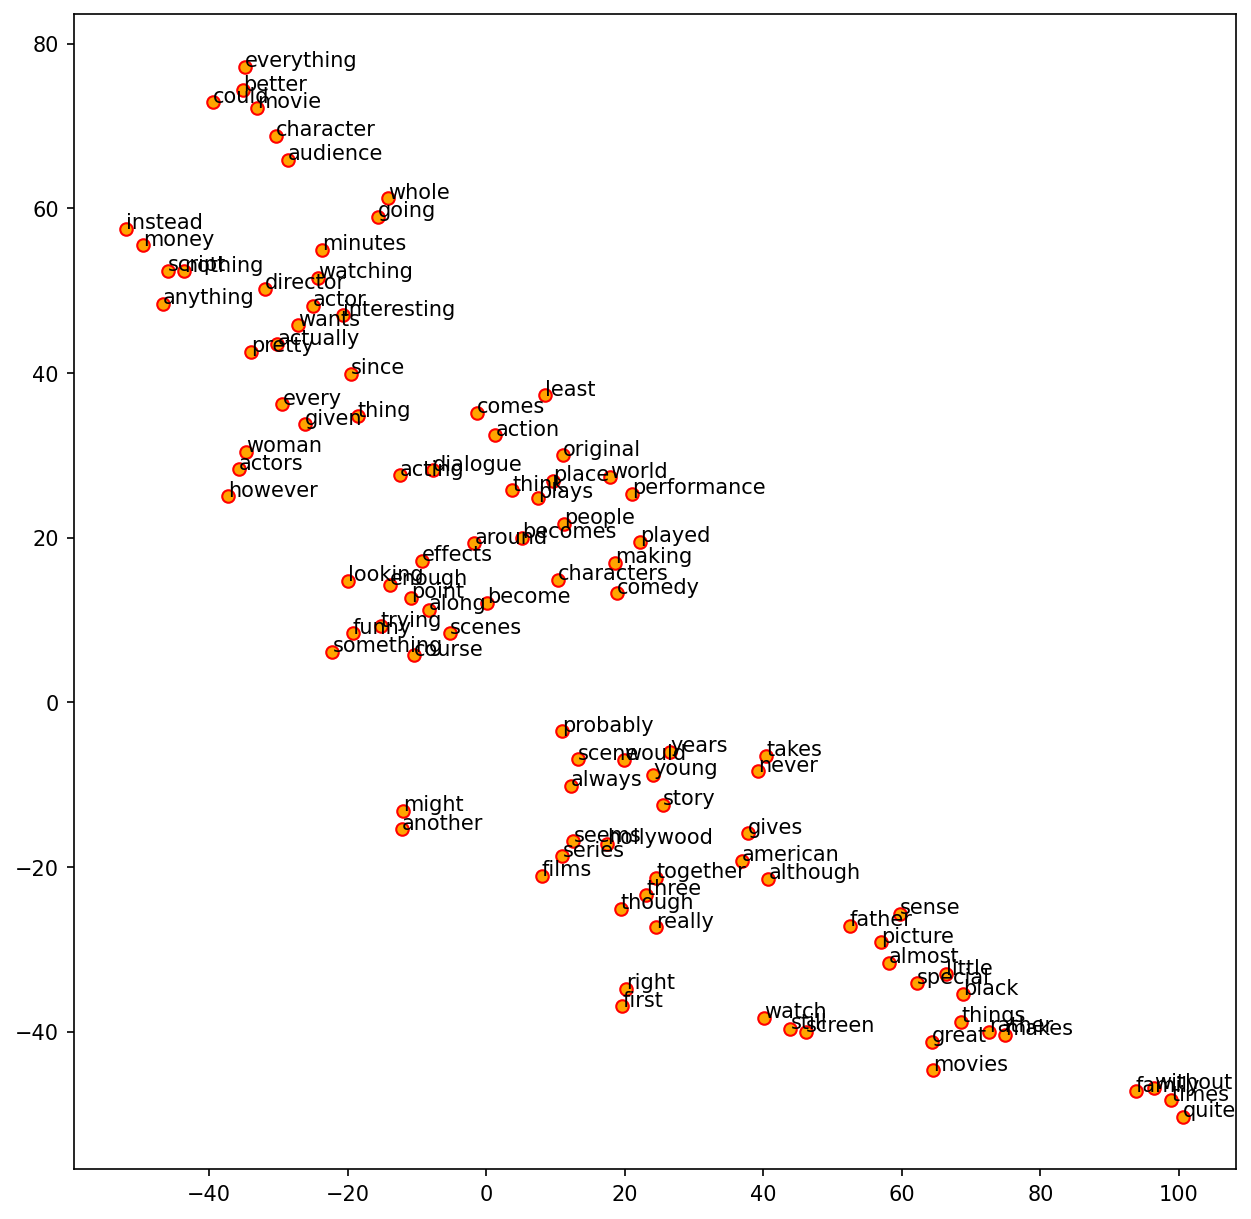

In [71]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[out_index[:100],])
labels= list(np.array(token_labels)[out_index[:100]])

len(labels)

plt.figure(figsize=(10, 10), dpi=150)
plt.scatter(T[:, 0], T[:,1], c= 'orange', edgecolors='r')
for label, x, y in zip(labels, T[:,0], T[:,1]):
  plt.annotate(label, xy=(x + 0.01, y+0.01),
               xytext=(0,0), textcoords='offset points')

# Model Comparisons

In [72]:
history = [
    history1, history2, history3, history4, history5, history6, history7
]
history = [i.history for i in history]
model_names = [
    'One-hot-dense', 'Embedding-dense', 'RNN', 'Two-RNN', 'Bidirect',
    'Hidden-Cell', 'Self-attention'
]

## Set color pallete
import seaborn as sns
qualitative_colors = sns.color_palette("Paired", len(history))

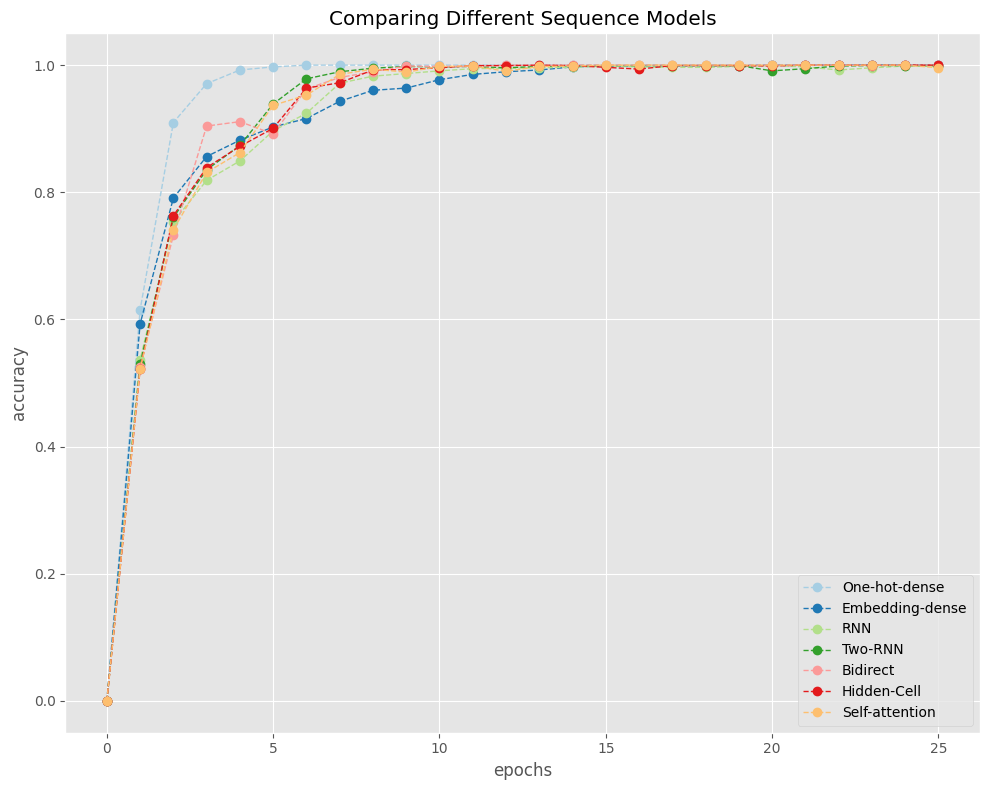

In [73]:
## Accuracy
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

##### General Observations
* Fully-connected network works better with one-hot encoding of texts (i.e., bag-of-words vectorized representations of texts)
* Embeddings are more useful when working with sequence models (e.g., RNN).
* The self-attention layer, in our current case, is on the entire input sequence, and therefore is limited in its effects.

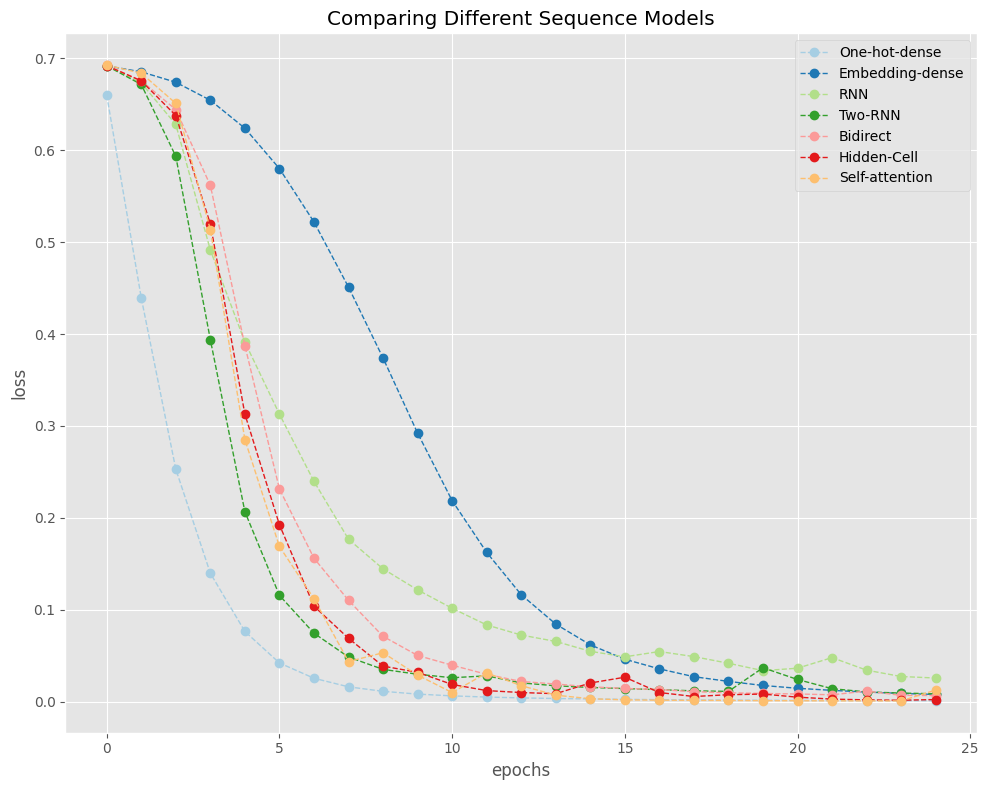

In [74]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()